# PoleFigurePhaseFractions.ipynb
Written by Adam Creuziger (adam.creuziger@nist.gov)

Oct 2017

    This data was developed by employees of the National Institute of Standards and Technology (NIST), an agency of the Federal Government. Pursuant to title 17 United States Code Section 105, works of NIST employees are not subject to copyright protection in the United States and are considered to be in the public domain.

    The data is provided by NIST as a public service and is expressly provided "AS IS." NIST MAKES NO WARRANTY OF ANY KIND, EXPRESS, IMPLIED OR STATUTORY, INCLUDING, WITHOUT LIMITATION, THE IMPLIED WARRANTY OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE, NON-INFRINGEMENT AND DATA ACCURACY. NIST does not warrant or make any representations regarding the use of the data or the results thereof, including but not limited to the correctness, accuracy, reliability or usefulness of the data. NIST SHALL NOT BE LIABLE AND YOU HEREBY RELEASE NIST FROM LIABILITY FOR ANY INDIRECT, CONSEQUENTIAL, SPECIAL, OR INCIDENTAL DAMAGES (INCLUDING DAMAGES FOR LOSS OF BUSINESS PROFITS, BUSINESS INTERRUPTION, LOSS OF BUSINESS INFORMATION, AND THE LIKE), WHETHER ARISING IN TORT, CONTRACT, OR OTHERWISE, ARISING FROM OR RELATING TO THE DATA (OR THE USE OF OR INABILITY TO USE THIS DATA), EVEN IF NIST HAS BEEN ADVISED OF THE POSSIBILITY OF SUCH DAMAGES.

    To the extent that NIST may hold copyright in countries other than the United States, you are hereby granted the non-exclusive irrevocable and unconditional right to print, publish, prepare derivative works and distribute the NIST data, in any medium, or authorize others to do so on your behalf, on a royalty-free basis throughout the world.

    You may improve, modify, and create derivative works of the data or any portion of the data, and you may copy and distribute such modifications or works. Modified works should carry a notice stating that you changed the data and should note the date and nature of any such change. Please explicitly acknowledge the National Institute of Standards and Technology as the source of the data: Data citation recommendations are provided below.

    Permission to use this data is contingent upon your acceptance of the terms of this agreement and upon your providing appropriate acknowledgments of NIST's creation of the data.


See: https://www.nist.gov/director/licensing

## Packages used in this Jupyter Notebook

In [1]:
import fortranformat as ff
import numpy as np 
import pandas as pd
import scipy as scipy
from scipy import interpolate 
from scipy import signal
import matplotlib.pyplot as plt
import mplstereonet
import math
import os

## Function: Read in Polefigure in .xpc format
MAUD uses an .xpc format for pole figures, likely derived from BearTex [1].  This format is similar to the General Intensity File Format in POPLA [2, appendix B2], with a slightly different header

[1] http://eps.berkeley.edu/~wenk/TexturePage/beartex.htm

[2] Popla Manual http://pajarito.materials.cmu.edu/rollett/27750/popLA_Manual.pdf


In [2]:
#        Adapted .xpc format parser, from 
#        https://github.com/usnistgov/texture
#        commit 9c0ac85
#        Program upf.py
# direct link: https://github.com/usnistgov/texture/blob/9c0ac8531276a5d8d27c0e895074ca66fda76608/src/upf.py

# .xpc format
# line with a phase, reflection and trailing '#' 
# 4 blank lines
# 1 line with lattice parameters
# 1 line with reflection and pole figure explaination
# 4 lines, with 18 terms each, integers - fixed width (fortran format)


def xpcformat(mode=None, filename=None):
    """
    Experimental pole figure format controller
    mode:
  ->    "steglich"
  ->    "bruker"  *.uxd file
  ->    "epf" (2011-Oct-6) epf popLA experimental pole figure format
    Returns the pole figure data as
  ->  the standard format (m x n numpy array)
  ->  each of axes stands for rotating (phi) and tilting (khi)
  ->  angle in the laboratory space.
    These angles will be angle and radius in the
    space onto which a pole figure is projected.
    conventions:
     tilting angle: khi
     rotating angle: phi
     dk: incremental khi angle
     dp: incremental phi angle
     nk: number of points along khi axis
     np: number of points along phi axis
     angles are converted into radian whenever possible
    Arguments
    =========
    mode     = None
    filename = None
    """

    print ('Pole Figure Parsing')

    if mode=='xpc':
        """
        Adapted .xpc format parser, from 
        https://github.com/usnistgov/texture
        commit 9c0ac85
        based on ready made popLA epf format parser
        consider the possibility of multiple number of polefigure
        ## phi must be 0~355, khi must be 0~90 with 5 as an ang
        resolution
        """
        print ('You are now reading experimental pole figure(s) :%s'%filename)
        blocks = open(filename, 'r').read().split('\n\n\n\n')[1:]
        #blocks = open(filename, 'rU').read().split('\n\n\n\n')[1:]   #changed, U mode deprecated
        print ('There are %s blocks of data found'%len(blocks))
        if len(blocks)==0:
            msg1 = 'xpc parser in upf assumes that pole figures are separated by 4 new lines'
            msg2 = ' searching %s finds no set of 4 new lines in '%filename
            msg  = '%s \n %s'%(msg1,msg2)
            raise IOError (msg)
            # blocks = parse_epf(filename)
        npf = len(blocks)
        if npf==0: raise IOError ('No pf block found.')

        datasets = []; max_khi = []
        if  npf>1: hkls=["HKL"] ## multiple number of pole figures in a file
        
        for part in blocks:
            line=part.split('\n')
            #print len(line)

            structureline=ff.FortranRecordReader('(6f10.4,1x,i4,1x,i4)')
            [a,b,c,alpha,beta,gamma,crystalclass,something]=structureline.read(line[1])   
            pfDefline=ff.FortranRecordReader('(1x,3i3,6f5.1,2i2)')
            [h,k,l,unknown1,tilt,tiltinc,unknown2,rotation,rotationinc,unknown3,unknown4]=pfDefline.read(line[2])
            
            #for the rest of the lines, do the following
            dataline=ff.FortranRecordReader('(1x,18i4)')
            
            # Pretty ugly code, but works...
            grouping=[[3,4,5,6],[7,8,9,10],[11,12,13,14],[15,16,17,18],[19,20,21,22],[23,24,25,26],
                      [27,28,29,30],[31,32,33,34],[35,36,37,38],[39,40,41,42],[43,44,45,46],[47,48,49,50],
                      [51,52,53,54],[55,56,57,58],[59,60,61,62],[63,64,65,66],[67,68,69,70],[71,72,73,74],
                     [75,76,77,78]] 
            
            
            dataset=[]
            for item in grouping:
                #print item[0],item[1],item[2],item[3] 
                parsed=dataline.read(line[item[0]])
                parsed.extend(dataline.read(line[item[1]]))
                parsed.extend(dataline.read(line[item[2]]))
                parsed.extend(dataline.read(line[item[3]]))
                dataset.append(parsed)
            #print dataset
            
            #Saves as a Pandas dataframe, and maps the 360 degree phi data from the 0 degree phi data
            #row and column indexes are by degrees
            df=pd.DataFrame(dataset, index=np.arange(0,91,5))
            df.columns=[np.arange(0,360,5)]
            df[360]=df.iloc[:,0]  #tried changing .loc to .iloc
            
            # Save the hkl value
            hkl = [h,k,l] #hkl
            #print hkl
            hkls.append(hkl)

            datasets.append(df)
            
        #print hkls
        print ("number of pole figures:"), len(datasets)

        return datasets, hkls
    else: raise IOError ('Unexpected mode is given')
    #return data

## Define function to take a pole figure (or series of pole figures) and series of coordinate pairs, returning an average intensity for all of the pole figures and coordinates

In [3]:
def pfIntensitySum(name, PoleFigures, Coordinates):

    """
    For each coordinate pair passed to this function, interpolate the pole figure to find intensity
    Average intenisity for all coordinate pairs
    Average intensity for all pole figures passed
    
    conventions:

    Input Arguments
    ========= 
    name: passed through program to help mark columns
    PoleFigures - series of 
    -> FORMAT
    Coordinates
    -> FORMAT
    array of coordinates (rotation,tilt)
  
    Output Arguments
    ========= 
    AverageIntensity Array for each pole figure with average intensity 
    """
        
    #print "Averaging Intensity from Pole Figures"
    AverageIntensity=[name]

    ## For each pole figure:
    for pf in PoleFigures:
        IntensityValues=[]
        #print "Pole Figure Data:"
        #print len(list(pf.columns.values))
        #print len(list(pf.index.values))
        #print pf    

        ## Interpolate the pole figure
        #set kx,ky=1 for linear interpolation, otherwise got odd behavior near zero on edges
        InterpPF=scipy.interpolate.RectBivariateSpline(list(pf.index.values),list(pf.columns.values), pf, kx=1, ky=1)

        ## For each coordinate:
        ## Read the value from the pole figure, append to new array
        #print Coordinates
        for index, row in Coordinates.iterrows():
            #print row['Tilt'], row['Rotation'], InterpPF.ev(row['Tilt'],row['Rotation'])
            IntensityValues.append(InterpPF.ev(row['Tilt'],row['Rotation']))

        #print IntensityValues
        #Factor of 100 is divided to convert from POPLA style format of 100 = 1 MRD/MUD
        AverageIntensity.append(sum(IntensityValues)/(100*len(IntensityValues)))

    #print AverageIntensity

    ## return average value
    return AverageIntensity



## Define function to create a hexagonal grid

Adapted from A. C. Rizzie, “Elaboration on the Hexagonal Grid and Spiral Method for Data Collection Via Pole Figures,” Spring 2008 [Online]. Available: http://www.bsu.edu/libraries/beneficencepress/mathexchange/05-01/rizzie.pdf. [Accessed: 13-Dec-2016]


In [4]:
def HexGrid(name, chi_max, angular_spacing):
    
#chi_max=90.0  #maximum tilt angle in degrees
#angular_spacing=7.0


    d_max=2.0*math.sin(math.radians(chi_max)/2.0)

    N=d_max/math.radians(angular_spacing)

    #print "Max Tilt: ", chi_max
    #print "Angular Spacing: ", angular_spacing

    xaxis=[]
    yaxis=[]

    j=0
    i=0
    y_j=0.0
    x_ij=0.0
    chi_ij=0.0
    phi_ij=0.0

    while np.multiply((math.sqrt(3)*(d_max)/(2*N)), j ) < d_max:

        y_j=np.multiply((math.sqrt(3)*(d_max)/(2*N)), j )
        #print "Current tilt: ", math.degrees(y_j)
        #print "X_ij list: ", x_ij ,"\n"

        #print "j: ",j,"\ty_j: ", y_j 
        #print "\n"    

        #print "x_ij limit: ", (math.sqrt(d_max*d_max-(y_j*y_j)))
        i=0
        x_ij=0.0
        while ((d_max/N)*i) <= (math.sqrt(d_max*d_max-(y_j*y_j))):

            #x.append(1)
            #print "b*j: ",j,"\ti: ", i, "\tx_ij: ", x_ij 

            if (j%2==0):
                #print "Even"
                x_ij=((d_max/N)*i)
                #x[j].append((R/N)*i)
            elif (j%2==1):
                #print "Odd"
                x_ij=((d_max/(2.0*N))+(d_max/N)*i)
                #x[j].append((R/(2*N))+(R/N)*i)
            else:
                pass


            #NextRotation=((R/N)*i)   
            #print "e j: ",j,"\ti: ", i, "\tx_ij: ", x_ij 

            d_ij=math.sqrt(x_ij*x_ij + y_j*y_j)
            chi_ij=2.0*math.asin(d_ij/2.0)
            if math.degrees(chi_ij) <= chi_max:
                if y_j==0:
                    #do once to avoid duplicates
                    #print "do some nothing"

                    phi_ij=((180.0/math.pi)*math.atan2(y_j,x_ij))
                    xaxis.append(math.degrees(chi_ij))
                    yaxis.append(phi_ij)

                    if x_ij!=0:
                        phi_ij=((180.0/math.pi)*math.atan2(y_j,-1.0*x_ij))
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)
                    else:
                        #removes reduntant rotation
                        pass

                else:
                    if x_ij>0:
#MCchange
                        #positive i values - quadrant I
                        phi_ij=((180.0/math.pi)*math.atan2(y_j,x_ij))
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)

                        #negative i values -quadrant II
                        phi_ij=((180.0/math.pi)*math.atan2(y_j,(-1.0*x_ij)))
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)

                        #quadrant III
                        phi_ij=((180.0/math.pi)*math.atan2(y_j,x_ij)+180.0)
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)

                        #quadrant IV
                        phi_ij=((180.0/math.pi)*math.atan2(y_j,(-1.0*x_ij))+180.0)
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)
#MCchange
                    else:
                        phi_ij=(90.0)
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)

                        phi_ij=(270.0)
                        xaxis.append(math.degrees(chi_ij))
                        yaxis.append(phi_ij)
                #print "j: ",j,"\ty_j: ", y_j , "\ti: ", i,  "\tx_ij: ", x_ij ,"\td_ij: ", d_ij ,"\tchi_ij: ",math.degrees(chi_ij), "\tphi_ij: ",phi_ij
                    #anglelist.append([math.degrees(chi_ij) ,phi_ij])

            else:
                #append anyway to debug
            #    xaxis.append(math.degrees(chi_ij))
            #    yaxis.append(phi_ij)
                #print "Excceds bounds at:"
                #print "\tchi_ij: ",chi_ij, "\td_max: ",d_max
                #print "\tchi_ij: ",math.degrees(chi_ij), "\td_max: ",math.degrees(d_max)
                #print "j: ",j,"\ty_j: ", y_j , "\ti: ", i,  "\tx_ij: ", x_ij ,"\td_ij: ", d_ij ,"\tchi_ij: ",math.degrees(chi_ij), "\tphi_ij: ",phi_ij
                pass
            #NextRotation=x_ij
            #print "Next Rotation: ", NextRotation


            ### Iterate
            i=i+1
        #print "X_ij list: ", x_ij ,"\n"
        #NextTilt= np.multiply((math.sqrt(3)*(d_max)/(2*N)), j+1 )
        #print "Next Tilt:", math.degrees(NextTilt)   


        ### Iterate
        j=j+1

        #print "\n"
        #print y_j

    d = {'Tilt' : xaxis, 'Rotation' : yaxis}
    #coordinates=pd.DataFrame(d)
    #MCchange
    coordinates=pd.DataFrame(d)
    Badvals = coordinates[coordinates['Rotation'] > 270.0].index
    coordinates.drop(Badvals , inplace=True)
    Badvals2 = coordinates[coordinates['Rotation'] < 180.0].index
    coordinates.drop(Badvals2 , inplace=True)
    #MCchange

    #print coordsDF.sort_values('Tilt')    
    return name, coordinates

## Define function to tilt and rotate

Adapted from C. F. Jatczak, J. A. Larson, and S. W. Shin, Retained austenite and its measurements by X-ray diffraction: an information manual. Warrendale, PA: Society of Automotive Engineers, 1980. 


In [5]:
# convert rotations per minute to radians per second
def rpm2radpsec(rpm):
    radpsec=(rpm*math.pi*2.0)/60.0
    return radpsec


In [6]:
def TiltRotate(name, time, datapoints, rpm,maxtilt,tiltcpm):
    #time=120  # in seconds
    #datapoints = 5000.0
    rotationspeed=(rpm2radpsec(rpm)) # radians per second
    #maxtilt=60.0  # in degrees
    tiltspeed=(tiltcpm/60.0)  #cycles per second

    #print time,  datapoints, rpm,maxtilt,tiltcpm
    
    timelist=np.ndarray.tolist(np.arange(0, time, time/datapoints))
    #print timelist

    rotationposition=[]
    tiltposition=[]


    #print rotationspeed

    #create the list of tilts and rotations
    for i,item in enumerate(timelist):
        #rotationposition.append(math.degrees(item*rotationspeed % 2.0*math.pi))
        #MCchange
        #####rotationposition.append((math.degrees(rotationspeed*item) % 360.0))
        rotationposition.append((math.degrees(rotationspeed*item) % 360.0))
        #MCchange
        tiltposition.append(maxtilt* signal.sawtooth(2 * np.pi * tiltspeed * item +np.pi/2, 0.5))

        #print "time:", item, "\tRotation: ", rotationposition[-1],  "\tTilt: ", tiltposition[i]


    #print rotationposition
    # function for tilt
    #56 cycles/minute


    #plt.plot(timelist, rotationposition, 'r',timelist, tiltposition, 'b')
    #plt.show()

    d = {'Tilt' : tiltposition, 'Rotation' : rotationposition}
    #coordinates=pd.DataFrame(d)
    #MCchange
    coordinates=pd.DataFrame(d)
    Badvals = coordinates[coordinates['Tilt'] > 0.0].index
    coordinates.drop(Badvals , inplace=True)
    Badvals2 = coordinates[coordinates['Rotation'] > 90.0].index
    coordinates.drop(Badvals2 , inplace=True)                
    #MCchange                
        #print coordsDF.sort_values('Tilt')    
    return name, coordinates


# Create list of positions to evaluate

## Single Sample Orientation

In [7]:
def SingleOrientation(name, tilt, rotation):
    coordslist=[[tilt,rotation]]
    xaxis=[]
    yaxis=[]
    for item in coordslist: 
        xaxis.append(item[0])
        yaxis.append(item[1])
    #coordslist[0][:]
    d = {'Tilt' : xaxis, 'Rotation' : yaxis}
    coordsDF=pd.DataFrame(d)
    return name, coordsDF

## Rings Perpendicular to a sample direction

In [8]:
# Perpendicular to ND
def RingPerpND(res):
    name="Ring Perpendicular to ND"
    yaxis=np.ndarray.tolist(np.arange(0.0, 360.0001, res))#rotation
    xaxis=[90.0] * len(yaxis) #tilt 
    d = {'Tilt' : xaxis, 'Rotation' : yaxis}
    coordsDF=pd.DataFrame(d)
    return name, coordsDF

In [9]:
# Perpendicular to RD
def RingPerpRD(res):
    name="Ring Perpendicular to RD"
    xaxis=np.ndarray.tolist(np.arange(0.0, 90.001, res))#tilt 
    #yaxis=[90.0] * len(xaxis) #rotation
    yaxis=[270.0] * len(xaxis) #rotation
    d = {'Tilt' : xaxis, 'Rotation' : yaxis}
    coordsDF=pd.DataFrame(d)
    return name, coordsDF

In [10]:
# Perpendicular to TD
def RingPerpTD(res):
    name="Ring Perpendicular to TD"
    xaxis=np.ndarray.tolist(np.arange(0.0, 90.001, res))#tilt 
    #yaxis=[0.0] * len(xaxis) #rotation
    yaxis=[180.0] * len(xaxis) #rotation
    d = {'Tilt' : xaxis, 'Rotation' : yaxis}
    coordsDF=pd.DataFrame(d)
    return name, coordsDF

## Generate average intensity based on pole figures and coordinates
- This section calculates the average intensity and saves to file
- Looks for the list of XPC files and calculates a table (.xlsx) for each

_Skip if you only wish to plot the sampling schemes_

In [18]:
#SchemeName,Coordinates=

# Get the current working directory path
cwd=os.getcwd()
#print cwd
xpcdatapath=os.path.abspath(os.path.join(os.path.dirname( cwd)))
#print xpcdatapath
#Folder=xpcdatapath+'/MAUD/XPCFiles'
Folder='C:\Research\Texture-Sampling-PhaseMeasurement-BiasErrors-master\MAUD\XPCFiles'
#SaveFolder="AveragedIntensites"  Temporary fix
SaveFolder='C:\Research\Texture-Sampling-PhaseMeasurement-BiasErrors-master\JupyterNotebooks\AveragedIntensites'

if not os.path.isdir(SaveFolder):
    os.makedirs(SaveFolder)
    
os.chdir(SaveFolder)


for file in os.listdir(Folder):
    print (file)
    if file.endswith(".xpc"):
        XPCfile=(os.path.join(Folder, file))
        
        #
        if "-" in file: 
            orientation, hw=file.split('-')
        else:
            orientation, ext=file.split('.')
            
        PhaseType= orientation[-1:]


    #for XPCfile in listoffiles:

        (pfs,hkllist)=xpcformat('xpc',XPCfile)

        #create subsets for phase fractions

        hkllist.append('2Pairs')
        hkllist.append('4Pairs')
        hkllist.append('MaxUnique')

        OutputList=[hkllist]

        for q in list([1,2,3,4,5,6,7,8,9,10,11,12,13]):

            if q==1: SchemeName,Coordinates=SingleOrientation("ND Single", 0.0,0.0)
            elif q==2: SchemeName,Coordinates=SingleOrientation("RD Single", 90.0,0.0)
            elif q==3: SchemeName,Coordinates=SingleOrientation("TD Single", 90.0,90.0)
            elif q==4: SchemeName,Coordinates=SingleOrientation("Morris", 60.0,90.0)
                ## Add other orientation

            elif q==5: SchemeName,Coordinates=RingPerpND(5.0)
            elif q==6: SchemeName,Coordinates=RingPerpRD(5.0)
            elif q==7: SchemeName,Coordinates=RingPerpTD(5.0)

                # re-arranged to match plotting
            elif q==8: SchemeName,Coordinates=TiltRotate("NoRotation-tilt60deg", 120.0, 1600.0, 0.0,60.0,56.0)
            elif q==9: SchemeName,Coordinates=TiltRotate("Rotation-NoTilt", 120.0, 1600.0, 30.0,0.0,56.0)
            elif q==10: SchemeName,Coordinates=TiltRotate("Rotation-60detTilt", 120.0, 5000.0, 30.0,60.0,56.0)
#MCchanges
#      elif q==11: SchemeName,Coordinates=HexGrid("HexGrid-90degTilt5degRes",90.0,5.0)
#             elif q==12: SchemeName,Coordinates=HexGrid("HexGrid-90degTilt22p5degRes",90.0,22.5)
#             elif q==13: SchemeName,Coordinates=HexGrid("HexGrid-60degTilt5degRes",60.0,5.0)        
    
    
            elif q==11: SchemeName,Coordinates=HexGrid("HexGrid-90degTilt5degRes",60.0,21.0)
            elif q==12: SchemeName,Coordinates=HexGrid("HexGrid-90degTilt22p5degRes",60.0,22.0)
            elif q==13: SchemeName,Coordinates=HexGrid("HexGrid-60degTilt5degRes",60.0,20.5)
#MCchanges                
            else: 
                print ("No Schemes of that index")
                break

            PfIS=pfIntensitySum(SchemeName,pfs,Coordinates)
            PfIS.append(np.mean([PfIS[2],PfIS[3]]))
            PfIS.append(np.mean([PfIS[1],PfIS[2],PfIS[3],PfIS[4]]))

            if PhaseType=="A":
                PfIS.append(np.mean([PfIS[1],PfIS[2],PfIS[3],PfIS[4],PfIS[7],PfIS[8],PfIS[9],PfIS[10]]))
            elif PhaseType=="F":
                PfIS.append(np.mean([PfIS[1],PfIS[2],PfIS[3],PfIS[5],PfIS[6],PfIS[7]])) 
                #used to include 4, exclude 5, but that is incorrect
            else:
                print ("Unrecognized Phase")

            OutputList.append(PfIS)  

            #print q,SchemeName
            #print "List of average pole Figure Intensities:\n", PfIS
            #print "Average of all pole figures listed: ", sum(PfIS)/len(PfIS)
            #print ""

            #np.mean()
        #print (XPCfile.rsplit('/',1))
        #directory, outfile=XPCfile.rsplit('/', 1)  #use this version for MAC
        directory, outfile=XPCfile.rsplit('\\', 1)  #use this version for Windows
        print (outfile)
        OutputList.append([XPCfile]) 
        IntensitiesDF=pd.DataFrame(OutputList)
        IntensitiesDF

        # save to excel

        s=""     

        writer = pd.ExcelWriter(s.join([outfile.split('.')[0], ".xlsx"]))
        IntensitiesDF.to_excel(writer,outfile)
        writer.save()
    else:
        print ("Not an .xpc file")
os.chdir("..")

alpha1F-HW10.xpc
Pole Figure Parsing
You are now reading experimental pole figure(s) :C:\Research\Texture-Sampling-PhaseMeasurement-BiasErrors-master\MAUD\XPCFiles\alpha1F-HW10.xpc
There are 8 blocks of data found
number of pole figures:
alpha1F-HW10.xpc
alpha1F-HW15.xpc
Pole Figure Parsing
You are now reading experimental pole figure(s) :C:\Research\Texture-Sampling-PhaseMeasurement-BiasErrors-master\MAUD\XPCFiles\alpha1F-HW15.xpc
There are 8 blocks of data found
number of pole figures:
alpha1F-HW15.xpc
alpha1F-HW20.xpc
Pole Figure Parsing
You are now reading experimental pole figure(s) :C:\Research\Texture-Sampling-PhaseMeasurement-BiasErrors-master\MAUD\XPCFiles\alpha1F-HW20.xpc
There are 8 blocks of data found
number of pole figures:
alpha1F-HW20.xpc
alpha1F-HW25.xpc
Pole Figure Parsing
You are now reading experimental pole figure(s) :C:\Research\Texture-Sampling-PhaseMeasurement-BiasErrors-master\MAUD\XPCFiles\alpha1F-HW25.xpc
There are 8 blocks of data found
number of pole figure

# Plots

# Plot pole figures of sampling positions

### Test functions

In [12]:
SchemeName,Coordinates=SingleOrientation("Morris", 60.0,90.0)
Coordinates

,Tilt,Rotation
0,60.0,90.0


### Simple plot to work out mplsteronet conventions

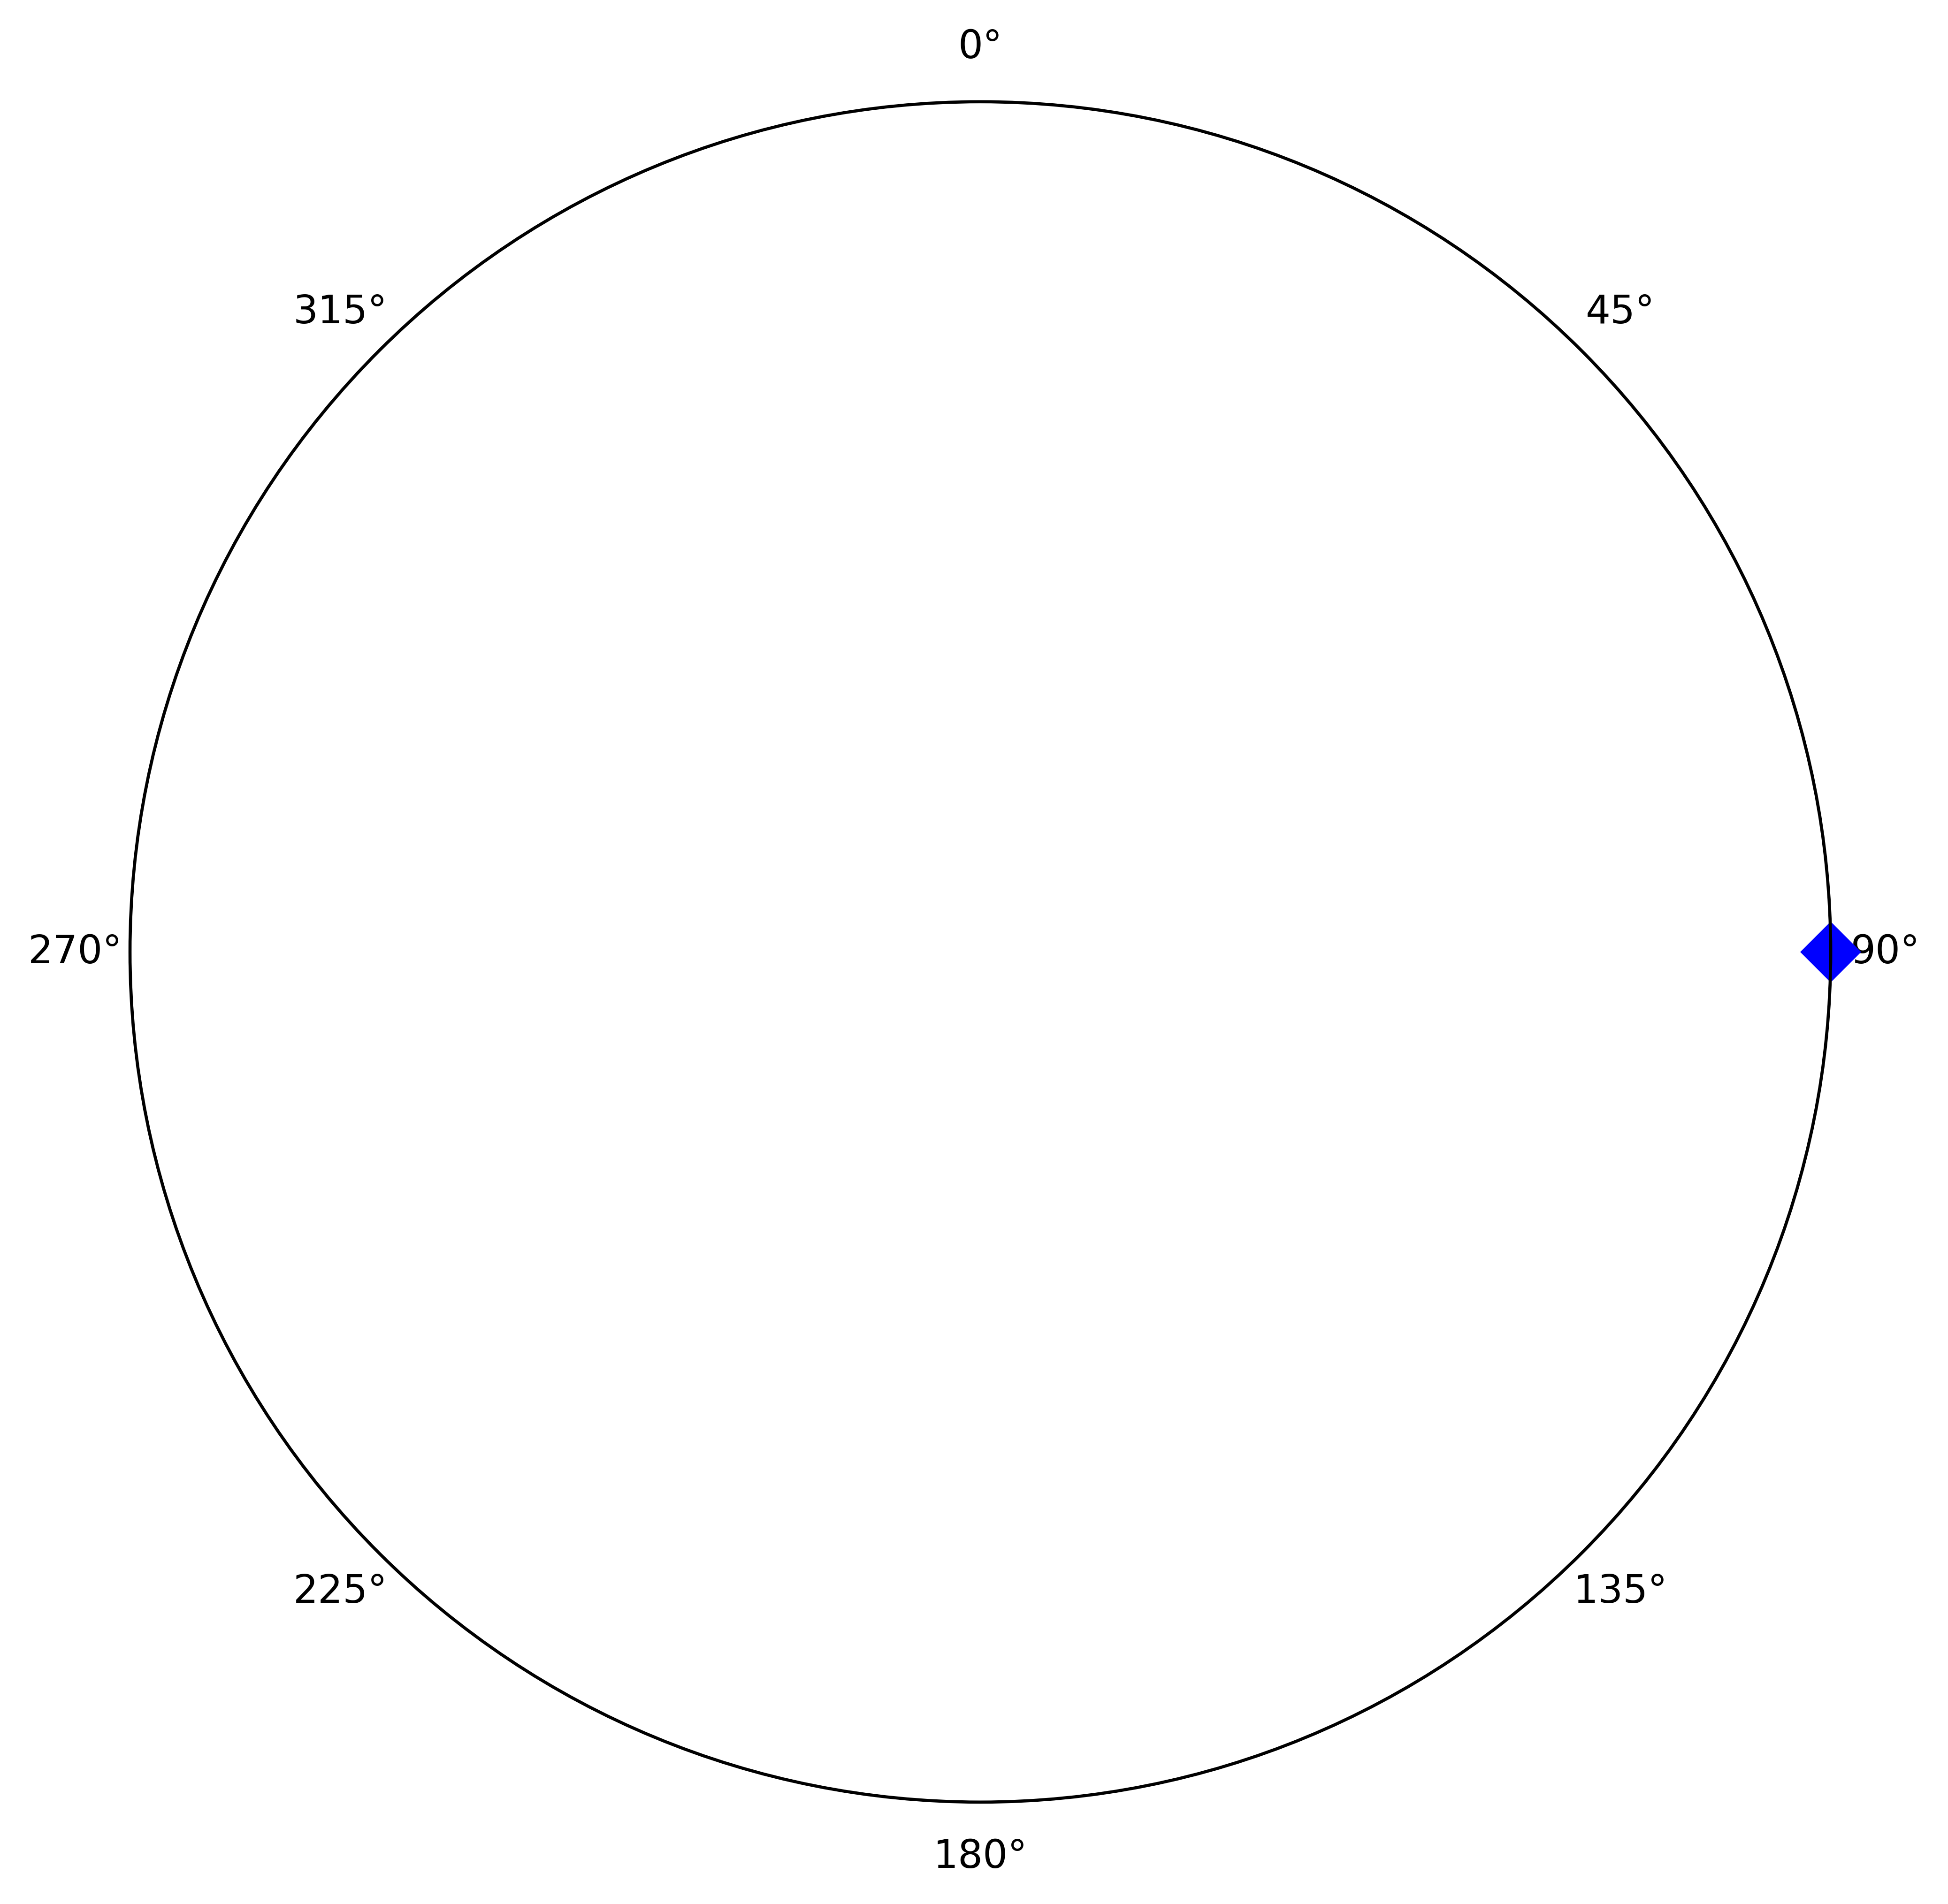

In [13]:
fig = plt.figure(figsize=(8,8), dpi=600)

ax2 = fig.add_subplot(111, projection='stereonet')

#SingleOrientation - Name, Tilt, Rotation
#SchemeName,Coordinates=SingleOrientation("RD Single", 90.0,180.0)
SchemeName,Coordinates=SingleOrientation("TD Single", 90.0,270.0)

dip, strike =Coordinates['Tilt'], Coordinates['Rotation']-90.0
l1=ax2.pole(strike, dip, 'bD', markersize=10, clip_on=False)
#dip tilts about the 0 axis (RD), left handed
#strike tilts about the normal axis (ND), left handed
#Looking at the bottom of the sphere, not the top
#this is just convention of mplstereonet, does not affect averaging methods

plt.show()

## Plot all the Sampling methods

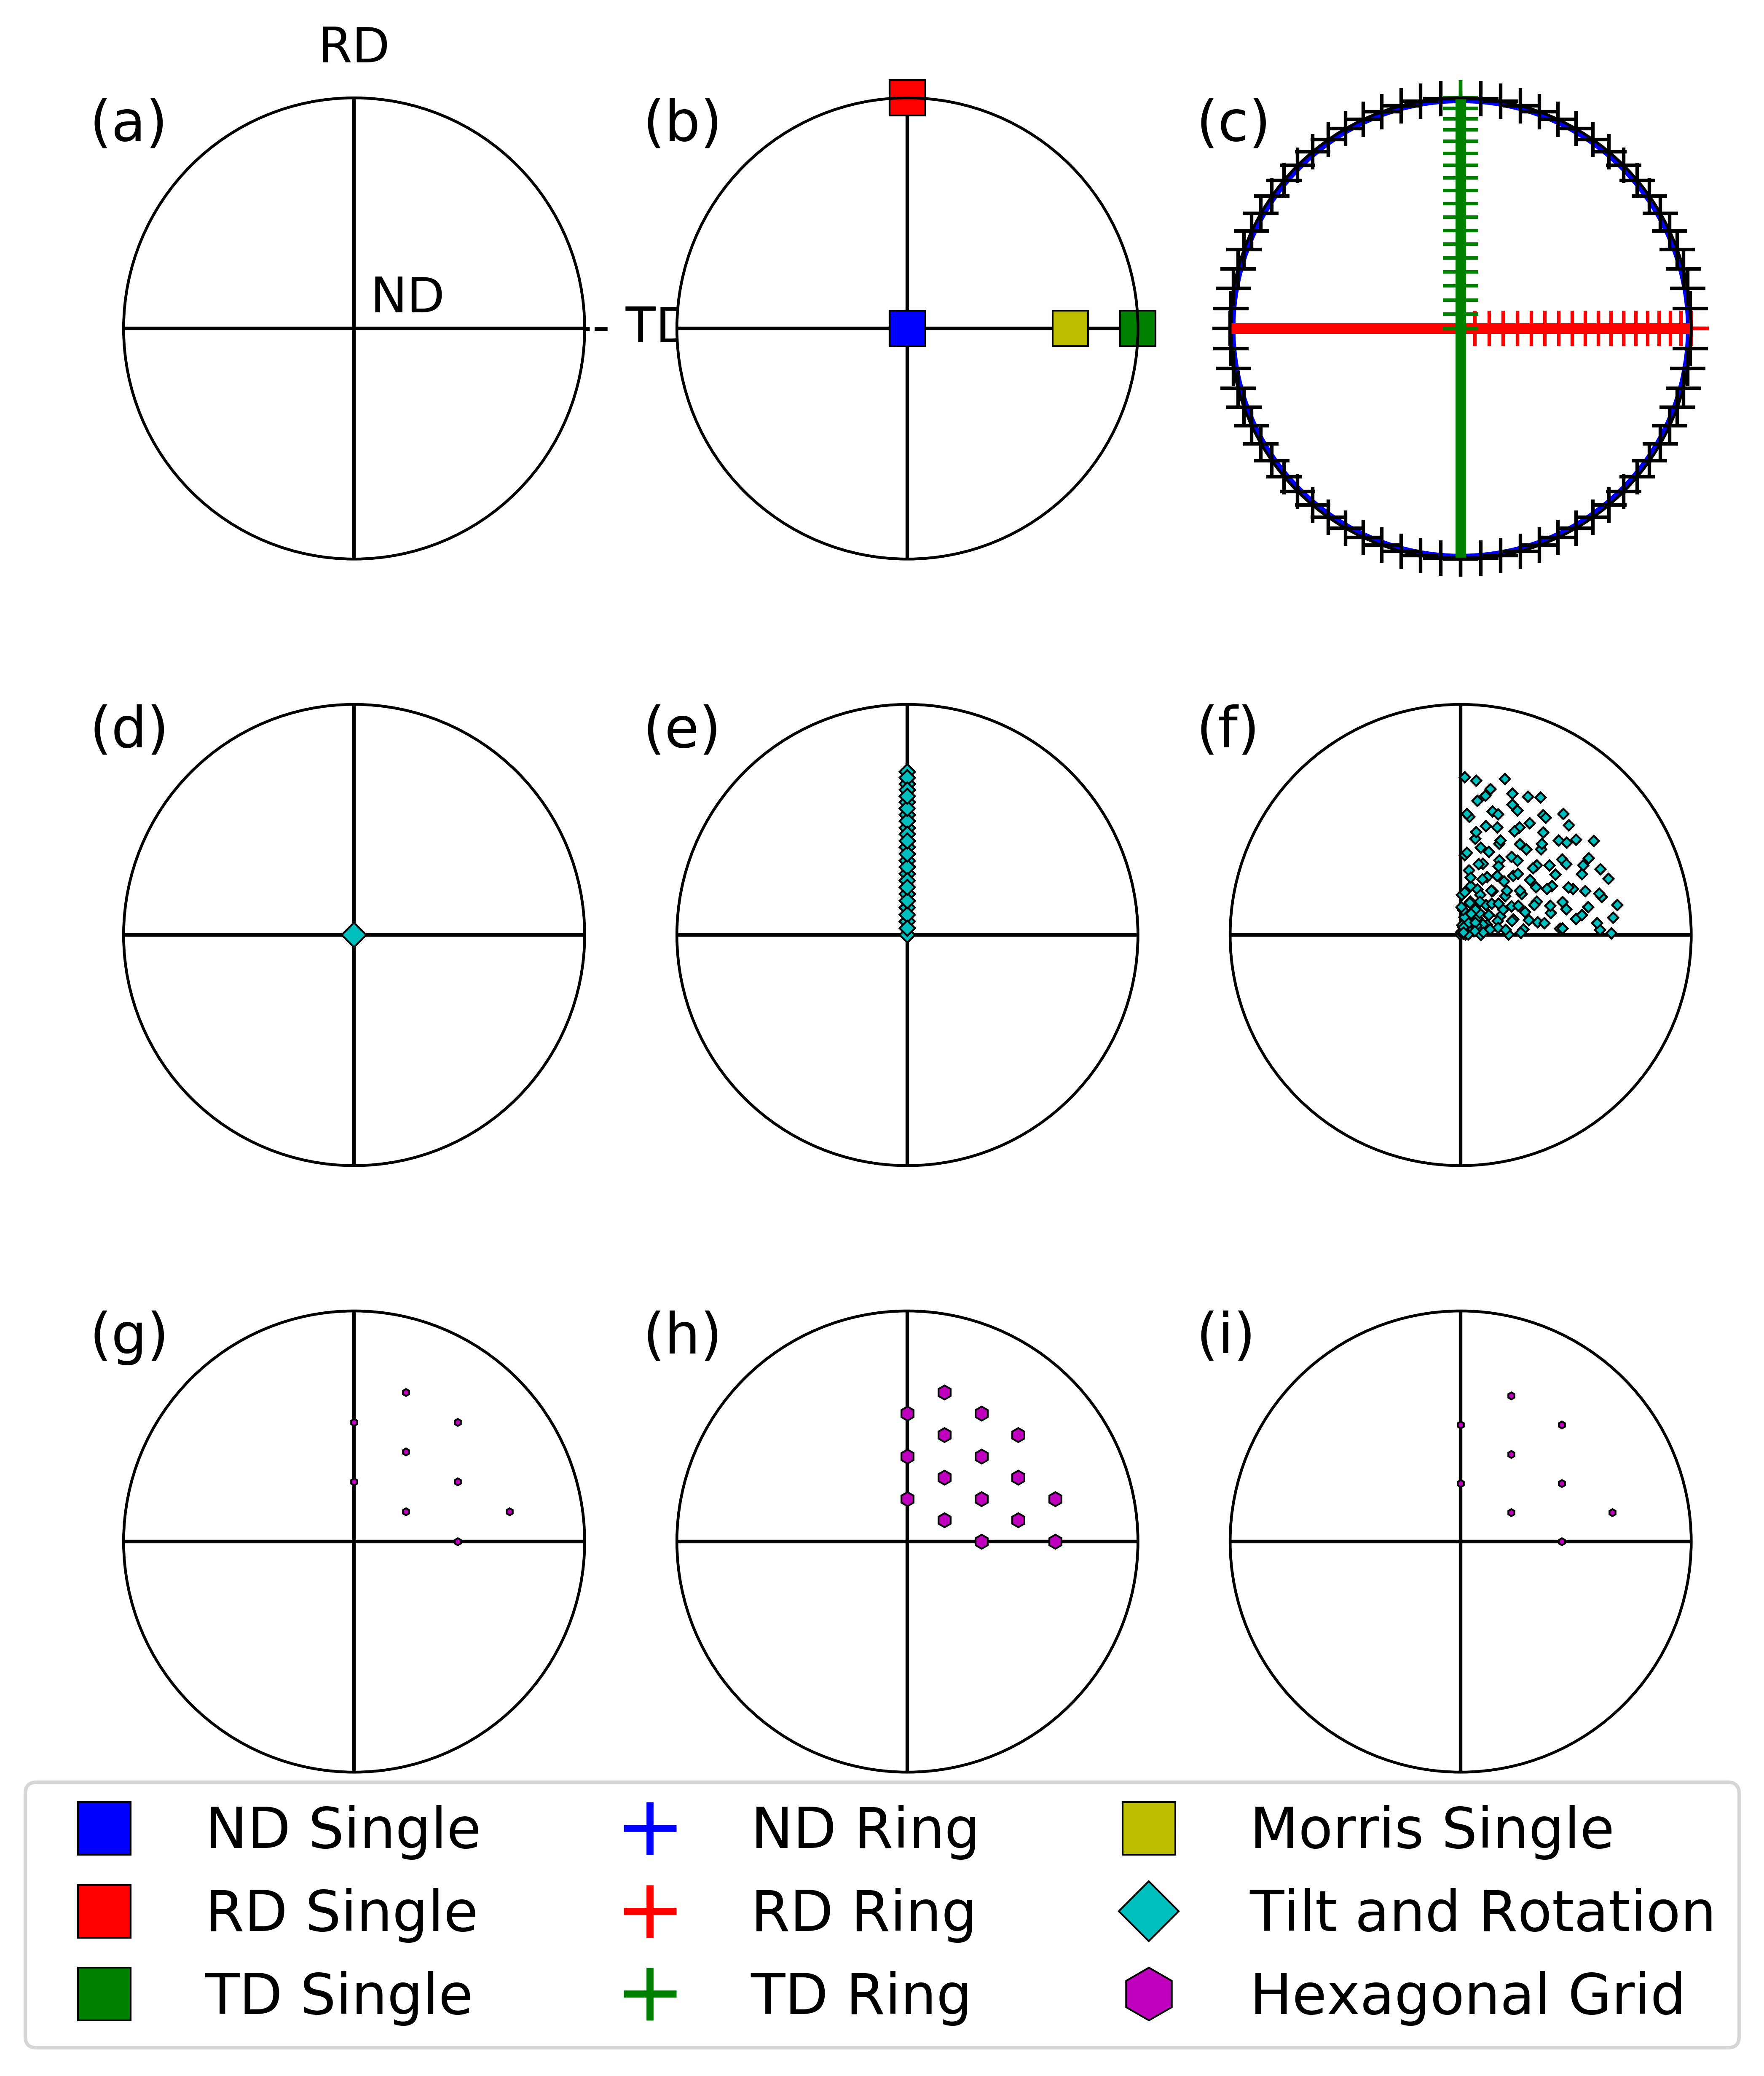

In [19]:
# Note - MPLStereonet uses a different angle convention (geosciences) than is used for crystallography
# A rotation of 90° is needed to align the coordiantes
# TD, Morris rotated by 270° to be in the same quadrant as Matlab
#dip = (Coordinates['Rotation']-90.0)


# 3 x 3 subplot grid
# single, ring, key
# Tilt/Rotate
# Hex Grids

fig = plt.figure(figsize=(8,9), dpi=600)


#key
ax1 = fig.add_subplot(331, projection='stereonet')
ax1.set_azimuth_ticks([0,90], labels=['RD','-- TD'],fontsize=14) 
ax1.plane(0.0, 90.0, 'k-', linewidth=1)
ax1.plane(90.0, 90.0, 'k-', linewidth=1)
ax1.annotate('(a)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax1.annotate('ND', xy=(0, 0), xytext=(0.1,0.1), fontsize=14)


#Single orientations

ax2 = fig.add_subplot(332, projection='stereonet')

ax2.plane(0.0, 90.0, 'k-', linewidth=1)
ax2.plane(90.0, 90.0, 'k-', linewidth=1)
            #if q==1: SchemeName,Coordinates=SingleOrientation("ND Single", 0.0,0.0)
            #elif q==2: SchemeName,Coordinates=SingleOrientation("RD Single", 90.0,0.0)
            #elif q==3: SchemeName,Coordinates=SingleOrientation("TD Single", 90.0,90.0)
            #elif q==4: SchemeName,Coordinates=SingleOrientation("Morris", 60.0,90.0)
                
SchemeName,Coordinates=SingleOrientation("ND Single", 0.0,0.0)
dip, strike =Coordinates['Tilt'], (Coordinates['Rotation']-90.0)
l1=ax2.pole(strike, dip, 'bs', markersize=10, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)

SchemeName,Coordinates=SingleOrientation("RD Single", 90.0,180.0)
dip, strike =Coordinates['Tilt'], (Coordinates['Rotation']-90.0)
l2=ax2.pole(strike, dip, 'rs', markersize=10, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)

SchemeName,Coordinates=SingleOrientation("TD Single", 90.0,270.0)
dip, strike =Coordinates['Tilt'], (Coordinates['Rotation']-90.0)
l3=ax2.pole(strike, dip, 'gs', markersize=10, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)

SchemeName,Coordinates=SingleOrientation("Morris", 60.0,270.0)
dip, strike =Coordinates['Tilt'], (Coordinates['Rotation']-90.0)
l4=ax2.pole(strike, dip, 'ys', markersize=10, clip_on=False, markeredgecolor='black', markeredgewidth=0.5)

ax2.set_azimuth_ticks([90,0], labels=['',''])
ax2.annotate('(b)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)

#ax1.grid()
#for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    #dip, strike =  row['Tilt'], row['Rotation']
    #ax1.pole(strike, dip, 'g^', markersize=5)
    
    
    #ax.plane(strike, dip, 'g-', linewidth=2)
    #ax.rake(strike, dip, -70)
    
# Ring Orientations
ax3 = fig.add_subplot(333, projection='stereonet')
ax3.annotate('(c)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax3.set_azimuth_ticks([90,0], labels=['','']) 


SchemeName,Coordinates=RingPerpND(5.0)
ax3.plane(0.0, 0.0, 'b-', linewidth=3)
ax3.plane(0.0, 180.0, 'b-', linewidth=3)
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax3.pole(strike, dip, 'k+', markersize=10, clip_on=False)



SchemeName,Coordinates=RingPerpRD(5.0)
ax3.plane(-90.0, 90.0, 'r-', linewidth=3) #0.0 (RD)-90.0 (Strike Converntion ) = -90.0Dip
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax3.pole(strike, dip, 'r+', markersize=10, clip_on=False)


SchemeName,Coordinates=RingPerpTD(5.0)
ax3.plane(0.0, 90.0, 'g-', linewidth=3)#90.0 (TD)-90.0 (Strike Converntion ) = 0.0Dip
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax3.pole(strike, dip, 'g+', markersize=10, clip_on=False)






ax4 = fig.add_subplot(334, projection='stereonet')
ax4.annotate('(d)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax4.set_azimuth_ticks([90,0], labels=['','']) 
ax4.plane(0.0, 90.0, 'k-', linewidth=1)
ax4.plane(90.0, 90.0, 'k-', linewidth=1)
SchemeName,Coordinates=TiltRotate("Rotation-NoTilt", 120.0, 1600.0, 30.0,0.0,56.0)
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax4.pole(strike, dip, 'cD', markersize=5, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)



ax5 = fig.add_subplot(335, projection='stereonet')
ax5.annotate('(e)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax5.plane(0.0, 90.0, 'k-', linewidth=1)
ax5.plane(90.0, 90.0, 'k-', linewidth=1)
ax5.set_azimuth_ticks([90,0], labels=['','']) 
SchemeName,Coordinates=TiltRotate("NoRotation-tilt60deg", 120.0, 1600.0, 0.0,60.0,56.0)
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax5.pole(strike, dip, 'cD', markersize=3, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)


ax6 = fig.add_subplot(336, projection='stereonet')
ax6.annotate('(f)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax6.plane(0.0, 90.0, 'k-', linewidth=1)
ax6.plane(90.0, 90.0, 'k-', linewidth=1)
ax6.set_azimuth_ticks([90,0], labels=['','']) 
SchemeName,Coordinates=TiltRotate("Rotation-60detTilt", 120.0, 5000.0, 30.0,60.0,56.0)
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax6.pole(strike, dip, 'cD', markersize=2, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)


    
# Hex Grids

ax7 = fig.add_subplot(337, projection='stereonet')
ax7.annotate('(g)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax7.plane(0.0, 90.0, 'k-', linewidth=1)
ax7.plane(90.0, 90.0, 'k-', linewidth=1)
ax7.set_azimuth_ticks([90,0], labels=['',''])
#MCchanges
SchemeName,Coordinates=HexGrid("HexGrid-90degTilt5degRes",60.0,21.0)
#SchemeName,Coordinates=HexGrid("HexGrid-90degTilt5degRes",90.0,5.0)
#MCchanges
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax7.pole(strike, dip, 'mh', markersize=2, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)


ax8 = fig.add_subplot(338, projection='stereonet')
ax8.annotate('(h)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax8.plane(0.0, 90.0, 'k-', linewidth=1)
ax8.plane(90.0, 90.0, 'k-', linewidth=1)
ax8.set_azimuth_ticks([90,0], labels=['','']) 
#MCchanges
#SchemeName,Coordinates=HexGrid("HexGrid-90degTilt22p5degRes",90.0,22.0)
SchemeName,Coordinates=HexGrid("HexGrid-90degTilt22p5degRes",60.0,15)
#MCchanges
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax8.pole(strike, dip, 'mh', markersize=4, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)



ax9 = fig.add_subplot(339, projection='stereonet')
ax9.annotate('(i)', xy=(0, 0), xytext=(-3.0,0.1), fontsize=16)
ax9.plane(0.0, 90.0, 'k-', linewidth=1)
ax9.plane(90.0, 90.0, 'k-', linewidth=1)
ax9.set_azimuth_ticks([90,0], labels=['','']) 
#MCchanges
SchemeName,Coordinates=HexGrid("HexGrid-60degTilt5degRes",60.0,20.5)
#SchemeName,Coordinates=HexGrid("HexGrid-60degTilt5degRes",60.0,5.0)
#MCchanges
for index, row in Coordinates.iterrows():
    #print row['Tilt'], row['Rotation']
    dip, strike =  row['Tilt'], (row['Rotation']-90.0)
    ax9.pole(strike, dip, 'mh', markersize=2, clip_on=False,markeredgecolor='black', markeredgewidth=0.5)


# Legend
import matplotlib.lines as mlines
blue_dot = mlines.Line2D([], [], color='white', marker='s', mfc='b',
                          markersize=15, label='',markeredgecolor='black', markeredgewidth=0.5)
red_dot = mlines.Line2D([], [], color='white', marker='s', mfc='r',
                          markersize=15, label='',markeredgecolor='black', markeredgewidth=0.5)
green_dot = mlines.Line2D([], [], color='white', marker='s', mfc='g',
                          markersize=15, label='',markeredgecolor='black', markeredgewidth=0.5)
yellow_dot = mlines.Line2D([], [], color='white', marker='s', mfc='y',
                          markersize=15, label='',markeredgecolor='black', markeredgewidth=0.5)

blue_plus = mlines.Line2D([], [], color='white', marker='+', mec='b', mew=2.0,
                          markersize=15, label='')
red_plus = mlines.Line2D([], [], color='white', marker='+', mec='r',mew=2.0,
                          markersize=15, label='')
green_plus = mlines.Line2D([], [], color='white', marker='+', mec='g',mew=2.0,
                          markersize=15, label='')

cyan_square = mlines.Line2D([], [], color='white', marker='D', mfc='c',
                          markersize=12, label='',markeredgecolor='black', markeredgewidth=0.5)

mag_hex = mlines.Line2D([], [], color='white', marker='h', mfc='m',
                          markersize=15, label='',markeredgecolor='black', markeredgewidth=0.5)

handles=[blue_dot, red_dot, green_dot,  blue_plus, red_plus, green_plus, yellow_dot, cyan_square, mag_hex]
labels=['ND Single','RD Single','TD Single', 'ND Ring','RD Ring','TD Ring','Morris Single', 'Tilt and Rotation', 'Hexagonal Grid' ]


#plt.figlegend((handles),(labels),'lower center', numpoints=1, ncol=3,fontsize=16,bbox_to_anchor=[0.46, -0.015])
plt.figlegend((handles),(labels),'lower center', numpoints=1, ncol=3,fontsize=16)


#swtich between saving figure and showing the figure

#plt.savefig("SamplingSchemes-Draft.eps", dpi=600,format="eps")
#plt.savefig("SamplingSchemes-Draft.pdf", dpi=600,format="pdf")
plt.savefig("SamplingSchemes-Draft.png", dpi=600,format="png")
plt.show()